### 라이브러리

In [1]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud

from konlpy import tag
from konlpy.corpus import kolaw
from konlpy.tag import Kkma, Komoran, Okt, Hannanum #Mecab은 윈도우에서 작동 불가능 #형태소 분석기 호출

from nltk.tokenize import sent_tokenize
from collections import Counter #데이터의 개수를 정리할 수 있는 모듈
from konlpy.utils import pprint #유니코드 문자 출력

import warnings
warnings.filterwarnings('ignore')

### Lyrics 불러오기

In [3]:
Lyrics = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/odatt/Lyrics_final.csv')

### 노래가사 이진분류(긍정, 부정)

In [4]:
# 행복, 희망 => 1(긍정), 슬픔, 분노 => 0(부정) 으로 이진분류

def rating_to_label(label):
    if label == 0 or label == 3:
        return 1
    else:
        return 0
    
Lyrics['y'] = Lyrics['label'].apply(lambda x: rating_to_label(x))
Lyrics_pos = Lyrics[Lyrics['y'] == 1]
Lyrics_neg = Lyrics[Lyrics['y'] == 0]
Lyrics_pos

,Lyrics,label,y
0,아침에 일어나 너에게 짧은 인사를 보낸다 아무리 멀리 떨어져 있어도 널 생각하고 있...,0,1
1,네가 맛있었다고 했던 살구빛 샐러드 맛있어서 먹고 싶어 네가 좋아했던 것들을 나에게...,0,1
2,마주치는 눈빛에 아기 아기 왠지 어색해 대체 고개를 숙여봐도 너의 발끝에 맘이 설레...,0,1
3,어깨동무까진 괜찮아 치마 손잡는 건 위험해 잘 자란 메세 진 괜찮아그래도 자냐는 메...,0,1
4,햇살이 가득 그댈 향한 가벼운 발걸음 콧노래 부르며 쇼윈도에 비친 모습을 한번 점검...,0,1
...,...,...,...
735,반쯤 미쳐가는 다 망가져 나의 삶넌 내게서 나를 지워가고 나를 부숴버려라 추락한 나...,3,1
736,무궁화 꽃이 피었습니다 빼고 다 멈춰지담 꽃이 피었습니다 현아 빼고 다 비켜 도망가...,3,1
737,아예 아예 아예 이렇게 감을 못 잡는 거야 말을 하는지 모르겠어 뭐야 싱긋싱긋 웃으...,3,1
738,나쁜 계집애 나난 나쁜 계집애 나쁜 계집애 모든 여자가 있는 고난 나난 모든 여자가...,3,1


### 긍정, 부정 감성 함수 구현

In [5]:
def LyricsWordCount(arrList, emotion):

    pos_word = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/odatt/pos_pol_word.txt', index_col = 0)
    pos_word = pd.DataFrame(pos_word).reset_index()
    pos_word.columns = ['pos_word']

    neg_word = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/odatt/neg_pol_word.txt', index_col = 0)
    neg_word = pd.DataFrame(neg_word).reset_index()
    neg_word.columns = ['neg_word']

    list = []
    result = []
    i=1

    # 감성 점수 구하기
    for Lyrics in arrList:
        neg_count = 0       # 부정 점수
        pos_count = 0       # 긍정 점수
        num = 0             # 감성 점수 
        
        # 긍정 점수 구하기
        for pos_text in pos_word['pos_word']:
            pos_find = Lyrics.find(pos_text)
            if(pos_find > -1):
                pos_count += 1
            else: pos_count += 0


        # 부정 점수 구하기
        for neg_text in neg_word['neg_word']:
            neg_find = Lyrics.find(neg_text)
            if(neg_find > -1):
                neg_count += 1
            else: pos_count += 0

        # 감성 점수 공식
        if emotion == '긍정':
          if pos_count == 0 or neg_count == 0:
            num = 0
          else:
            num = pos_count/(pos_count + neg_count)
            
        elif emotion == '부정':
          if pos_count == 0 or neg_count == 0:
            num = 0
          else:
            num = neg_count/(pos_count + neg_count)

        # 긍, 부정 결과
        if emotion == '긍정':
          if num >= 0.5:
            result = '긍정'
          elif num < 0.5:
            result = '부정'
        
        if emotion == '부정':
          if num >= 0.5:
            result = '부정'
          elif num < 0.5:
            result = '긍정'

        srt = f"{i}번 노래 결과 -> 긍정 : {pos_count}, 부정 : {neg_count} , 감성 점수 : {round(num,3)}  {result}"
        i = i + 1
        list.append(srt)
    return list

pos_result = LyricsWordCount(Lyrics_pos['Lyrics'], "긍정")
neg_result = LyricsWordCount(Lyrics_neg['Lyrics'], "부정")

print('긍정 노래')
for pos in pos_result:
    print(pos)

print('부정 노래')
for neg in neg_result:
    print(neg)


긍정 노래
1번 노래 결과 -> 긍정 : 10, 부정 : 6 , 감성 점수 : 0.625  긍정
2번 노래 결과 -> 긍정 : 4, 부정 : 0 , 감성 점수 : 0  부정
3번 노래 결과 -> 긍정 : 4, 부정 : 3 , 감성 점수 : 0.571  긍정
4번 노래 결과 -> 긍정 : 6, 부정 : 3 , 감성 점수 : 0.667  긍정
5번 노래 결과 -> 긍정 : 6, 부정 : 1 , 감성 점수 : 0.857  긍정
6번 노래 결과 -> 긍정 : 11, 부정 : 3 , 감성 점수 : 0.786  긍정
7번 노래 결과 -> 긍정 : 7, 부정 : 4 , 감성 점수 : 0.636  긍정
8번 노래 결과 -> 긍정 : 7, 부정 : 4 , 감성 점수 : 0.636  긍정
9번 노래 결과 -> 긍정 : 11, 부정 : 2 , 감성 점수 : 0.846  긍정
10번 노래 결과 -> 긍정 : 23, 부정 : 11 , 감성 점수 : 0.676  긍정
11번 노래 결과 -> 긍정 : 8, 부정 : 4 , 감성 점수 : 0.667  긍정
12번 노래 결과 -> 긍정 : 9, 부정 : 6 , 감성 점수 : 0.6  긍정
13번 노래 결과 -> 긍정 : 7, 부정 : 6 , 감성 점수 : 0.538  긍정
14번 노래 결과 -> 긍정 : 6, 부정 : 2 , 감성 점수 : 0.75  긍정
15번 노래 결과 -> 긍정 : 10, 부정 : 2 , 감성 점수 : 0.833  긍정
16번 노래 결과 -> 긍정 : 9, 부정 : 5 , 감성 점수 : 0.643  긍정
17번 노래 결과 -> 긍정 : 7, 부정 : 5 , 감성 점수 : 0.583  긍정
18번 노래 결과 -> 긍정 : 1, 부정 : 1 , 감성 점수 : 0.5  긍정
19번 노래 결과 -> 긍정 : 5, 부정 : 4 , 감성 점수 : 0.556  긍정
20번 노래 결과 -> 긍정 : 3, 부정 : 1 , 감성 점수 : 0.75  긍정
21번 노래 결과 -> 긍정 : 10, 부정 : 9 , 감성 점수 : 0.526  긍

In [6]:
def Total_pos(list) :
    count = 0
    for i in list:
        if(i[len(i)-2:len(i)] == '긍정'):
            count = count + 1

    return count        

sum = Total_pos(pos_result)
print('긍정 정확도: ', sum/len(Lyrics_pos))

def Total_neg(list) :
    count = 0
    for i in list:
        if(i[len(i)-2:len(i)] == '부정'):
            count = count + 1

    return count        

sum = Total_neg(pos_result)
print('부정 정확도: ', sum/len(Lyrics_pos))

긍정 정확도:  0.5838150289017341
부정 정확도:  0.4161849710982659


In [7]:
# 긍정.csv 파일 저장
import csv
with open('KUN_pos.csv', 'w', newline= '\n') as f:
  writer = csv.writer(f)
  writer.writerow(pos_result)

In [8]:
# 부정.csv 파일 저장
import csv
with open('KUN_neg.csv', 'w', newline= '\n') as f:
  writer = csv.writer(f)
  writer.writerow(neg_result)

### 말뭉치 생성 및 wordcloud

In [9]:
Lyrics_knu = pd.read_csv('/content/Lyrics_Knu.csv')
Lyrics_kosac = pd.read_csv('/content/Lyrics_koSac (1).csv')


Lyrics_knu_pos = Lyrics_knu[Lyrics_knu['pos_neg'] == 1]
Lyrics_knu_pos_happy = Lyrics_knu_pos[Lyrics_knu_pos['label'] == 0]
Lyrics_knu_pos_sad = Lyrics_knu_pos[Lyrics_knu_pos['label'] == 1]
Lyrics_knu_pos_anger = Lyrics_knu_pos[Lyrics_knu_pos['label'] == 2]
Lyrics_knu_pos_hope = Lyrics_knu_pos[Lyrics_knu_pos['label'] == 3]

Lyrics_knu_neg = Lyrics_knu[Lyrics_knu['pos_neg'] == 1]
Lyrics_knu_neg_happy = Lyrics_knu_neg[Lyrics_knu_neg['label'] == 0]
Lyrics_knu_neg_sad = Lyrics_knu_neg[Lyrics_knu_neg['label'] == 1]
Lyrics_knu_neg_anger = Lyrics_knu_neg[Lyrics_knu_neg['label'] == 2]
Lyrics_knu_neg_hope = Lyrics_knu_neg[Lyrics_knu_neg['label'] == 3]


In [10]:
# 말뭉치 생성
corpus_pos = "".join(Lyrics_knu_pos['Lyrics'].tolist())
corpus_neg = "".join(Lyrics_knu_neg['Lyrics'].tolist())
corpus_neg[:50]


'아침에 일어나 너에게 짧은 인사를 보낸다 아무리 멀리 떨어져 있어도 널 생각하고 있어 늦은'

### 긍정

In [11]:
def preprocessing(lyric,okt,remove_stopwords=False,stop_words=[]):
    text=re.sub('[^가-힣a-zA-Zㄱ-ㅎㅏ-ㅣ\\s]',' ',lyric) #200번째 가사

    lyric_word=okt.morphs(text)
    
    if remove_stopwords:
        lyric_word=[token for token in lyric_word if not token in stop_words]
    
    return lyric_word

stop_words = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
Lyrics_words = pd.read_csv("/content/Lyrics_word.txt").values.tolist()
# ㄴ 불용어 사전 업데이트 필요
# 시간, 그녀, 생각, 소리, 우리, 여자, 자신, 사회, 문제 => 키워드는 포함 x

stop_words.append(Lyrics_words)

clean_train_happy =[]
clean_train_sad =[]
clean_train_anger =[]
clean_train_hope =[]

kkma = Kkma()
okt = Okt()

# 1 긍정 / 행복
for lyric in Lyrics_knu_pos_happy['Lyrics']:
    if type(lyric)==str:
        clean_train_happy.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_happy.append([])


# 0 긍정 / 슬픔
for lyric in Lyrics_knu_pos_sad['Lyrics']:
    if type(lyric)==str:
        clean_train_sad.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_sad.append([])

# 2 긍정 / 분노
for lyric in Lyrics_knu_neg_anger['Lyrics']:
    if type(lyric)==str:
        clean_train_anger.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_anger.append([])


# 3 긍정 / 희망 
for lyric in Lyrics_knu_neg_hope['Lyrics']:
    if type(lyric)==str:
        clean_train_hope.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_hope.append([])


In [12]:
word_pos_happy = []
for i in clean_train_happy:
  for two_pos_word_happy in i:
    if len(two_pos_word_happy) >=2 :
      word_pos_happy.append(two_pos_word_happy)

word_pos_sad = []
for i in clean_train_sad:
  for two_pos_word_sad in i:
    if len(two_pos_word_sad) >=2 :
      word_pos_sad.append(two_pos_word_sad)

word_pos_anger = []
for i in clean_train_anger:
  for two_pos_word_anger in i:
    if len(two_pos_word_anger) >=2 :
      word_pos_anger.append(two_pos_word_anger)

word_pos_hope = []
for i in clean_train_hope:
  for two_pos_word_hope in i:
    if len(two_pos_word_hope) >=2 :
      word_pos_hope.append(two_pos_word_hope)


In [21]:
# 추출된 단어를 count해주는 함수
def getNounCnt(post_list):
    noun_cnt = {}
    
    for noun in post_list:
        if noun_cnt.get(noun):
            noun_cnt[noun] +=1
        else:
            noun_cnt[noun] = 1
    return noun_cnt
 
goal_dict_happy = getNounCnt(word_pos_happy)
goal_series_happy = pd.Series(goal_dict_happy)
goal_cnt_happy=dict(zip(goal_series_happy[goal_series_happy>=2].index.tolist(), goal_series_happy[goal_series_happy>=2].values.tolist()))

goal_dict_sad = getNounCnt(word_pos_sad)
goal_series_sad = pd.Series(goal_dict_sad)
goal_cnt_sad=dict(zip(goal_series_sad[goal_series_sad>=2].index.tolist(), goal_series_sad[goal_series_sad>=2].values.tolist()))

goal_dict_anger = getNounCnt(word_pos_anger)
goal_series_anger = pd.Series(goal_dict_anger)
goal_cnt_anger=dict(zip(goal_series_anger[goal_series_anger>=2].index.tolist(), goal_series_anger[goal_series_anger>=2].values.tolist()))

goal_dict_hope = getNounCnt(word_pos_hope)
goal_series_hope = pd.Series(goal_dict_hope)
goal_cnt_hope=dict(zip(goal_series_hope[goal_series_hope>=2].index.tolist(), goal_series_hope[goal_series_hope>=2].values.tolist()))

{'아침': 40, '일어나': 5, '에게': 120, '짧은': 5, '인사': 7, '아무리': 5, '멀리': 14, '떨어져': 3, '있어도': 10, '생각': 102, '하고': 77, '있어': 48, '늦은': 6, '편지': 3, '쓸게': 2, '반가운': 4, '사진': 10, '표정': 13, '만큼': 29, '아름다운': 24, '나날': 3, '이기': 7, '바람': 53, '불어와': 2, '어깨': 9, '에도': 19, '있니': 6, '숫자': 4, '근대': 6, '아직': 27, '까지': 36, '여기': 11, '언제': 23, '까지나': 5, '하나': 59, '좋아한단': 2, '나를': 103, '웃음': 34, '짓게': 6, '번호': 4, '때로는': 6, '지쳐': 3, '어도': 2, '당신': 309, '있고': 6, '다우': 4, '감으니': 2, '있는': 44, '같아': 48, '나타날': 2, '우연히': 7, '문득': 7, '돌아': 7, '있을게': 6, '가장': 18, '얼굴': 24, '눈물': 37, '해도': 30, '환하게': 6, '거야': 80, '오늘': 87, '일이': 10, '오래전': 5, '그날': 14, '처럼': 131, '아름답게': 2, '해내': 2, '사랑': 591, '빠지고': 5, '싶어': 57, '기억': 42, '해줘': 31, '보고': 43, '싶은': 36, '사람': 78, '안녕': 18, '눈빛': 15, '아기': 34, '왠지': 11, '대체': 6, '고개': 7, '숙여': 2, '봐도': 20, '발끝': 5, '조금씩': 17, '내게로': 13, '천천히': 12, '걸음': 13, '숨길': 3, '없어진': 2, '가는데': 2, '어서': 8, '살며시': 13, '들어': 15, '보면도': 2, '살짝': 12, '맞춰줘': 2, '하시겠습니까': 3, '혼자': 14, '아주': 12, '오래': 5

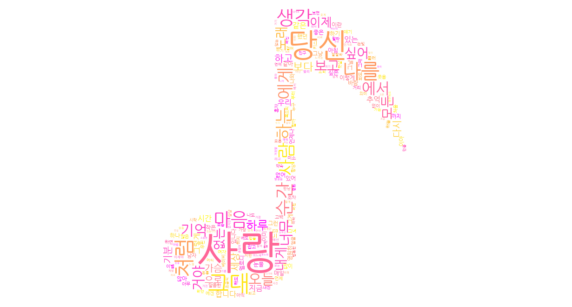

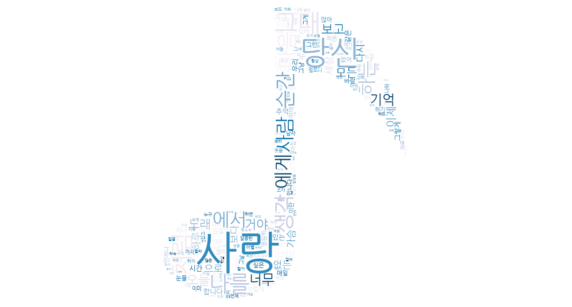

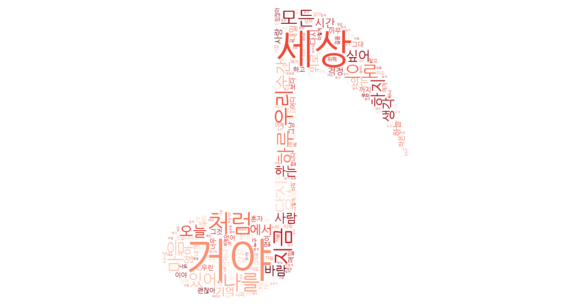

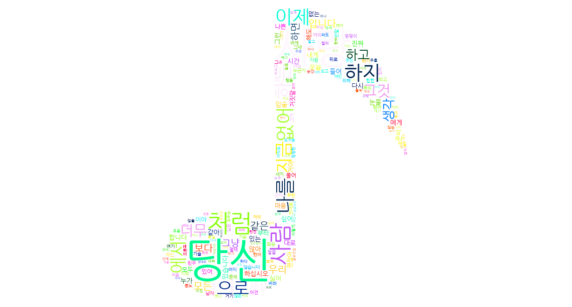

In [79]:
from PIL import Image
import numpy as np
%matplotlib inline

# 웹사이트에서 iconpp.png라는 파일을 다운받아 분석 환경에 미리 upload 해줍니다.
icon=Image.open('/content/pngegg.png')
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)

wc1 = WordCloud(font_path="/content/NanumGothic.ttf",                           #폰트
               background_color='white',                              #배경색
               width=800, height=1200,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask,
              colormap = 'spring'
              ) 

wc2 = WordCloud(font_path='/content/NanumGothic.ttf',                           #폰트
               background_color='white',                              #배경색
               width=800, height=600,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask
                , colormap = 'PuBu'
              ) 

wc3 = WordCloud(font_path='/content/NanumGothic.ttf',                           #폰트
               background_color='white',                              #배경색
               width=800, height=600,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask
                , colormap = 'Reds'
              )  

wc4 = WordCloud(font_path='/content/NanumGothic.ttf',                           #폰트
               background_color='white',                              #배경색
               width=800, height=600,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask
                , colormap = 'gist_ncar'
             )

#행복 
cloud1 = wc1.generate_from_frequencies(goal_cnt_sad)              #사전형태의 데이터
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud1,interpolation="bilinear")

# # 슬픔  
cloud2 = wc2.generate_from_frequencies(goal_cnt_sad)              #사전형태의 데이터
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud2,interpolation="bilinear")

# # 분노 
cloud3 = wc3.generate_from_frequencies(goal_cnt_anger)              #사전형태의 데이터
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud3,interpolation="bilinear")

# # 희망 
cloud4 = wc4.generate_from_frequencies(goal_cnt_hope)              #사전형태의 데이터
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud4,interpolation="bilinear")


### 부정 

In [80]:
def preprocessing(lyric,okt,remove_stopwords=False,stop_words=[]):
    text=re.sub('[^가-힣a-zA-Zㄱ-ㅎㅏ-ㅣ\\s]',' ',lyric) #200번째 가사

    lyric_word=okt.morphs(text)
    
    if remove_stopwords:
        lyric_word=[token for token in lyric_word if not token in stop_words]
    
    return lyric_word

stop_words = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
Lyrics_words = pd.read_csv("/content/Lyrics_word.txt").values.tolist()
# ㄴ 불용어 사전 업데이트 필요
# 시간, 그녀, 생각, 소리, 우리, 여자, 자신, 사회, 문제 => 키워드는 포함 x

stop_words.append(Lyrics_words)

clean_train_neg_happy =[]
clean_train_neg_sad =[]
clean_train_neg_anger =[]
clean_train_neg_hope =[]

kkma = Kkma()
okt = Okt()

# 1 긍정 / 행복
for lyric in Lyrics_knu_neg_happy['Lyrics']:
    if type(lyric)==str:
        clean_train_neg_happy.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_neg_happy.append([])


# 0 긍정 / 슬픔
for lyric in Lyrics_knu_neg_sad['Lyrics']:
    if type(lyric)==str:
        clean_train_neg_sad.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_neg_sad.append([])

# 2 긍정 / 분노
for lyric in Lyrics_knu_neg_anger['Lyrics']:
    if type(lyric)==str:
        clean_train_neg_anger.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_neg_anger.append([])


# 3 긍정 / 희망 
for lyric in Lyrics_knu_neg_hope['Lyrics']:
    if type(lyric)==str:
        clean_train_neg_hope.append(preprocessing(lyric,okt,remove_stopwords=True,stop_words=stop_words))
    else:
        clean_train_neg_hope.append([])


In [81]:
word_neg_happy = []
for i in clean_train_neg_happy:
  for two_neg_word_happy in i:
    if len(two_neg_word_happy) >=2 :
      word_neg_happy.append(two_neg_word_happy)

word_neg_sad = []
for i in clean_train_neg_sad:
  for two_neg_word_sad in i:
    if len(two_neg_word_sad) >=2 :
      word_neg_sad.append(two_neg_word_sad)

word_neg_anger = []
for i in clean_train_neg_anger:
  for two_neg_word_anger in i:
    if len(two_neg_word_anger) >=2 :
      word_neg_anger.append(two_neg_word_anger)

word_neg_hope = []
for i in clean_train_neg_hope:
  for two_neg_word_hope in i:
    if len(two_neg_word_hope) >=2 :
      word_neg_hope.append(two_neg_word_hope)


In [84]:
# 추출된 단어를 count해주는 함수
def getNounCnt(post_list):
    noun_cnt = {}
    
    for noun in post_list:
        if noun_cnt.get(noun):
            noun_cnt[noun] +=1
        else:
            noun_cnt[noun] = 1
    return noun_cnt
 
goal_dict_neg_happy = getNounCnt(word_neg_happy)
goal_series_neg_happy = pd.Series(goal_dict_neg_happy)
goal_cnt_neg_happy=dict(zip(goal_series_neg_happy[goal_series_neg_happy>=2].index.tolist(), goal_series_neg_happy[goal_series_neg_happy>=2].values.tolist()))

goal_dict_neg_sad = getNounCnt(word_neg_sad)
goal_series_neg_sad = pd.Series(goal_dict_neg_sad)
goal_cnt_neg_sad=dict(zip(goal_series_neg_sad[goal_series_neg_sad>=2].index.tolist(), goal_series_neg_sad[goal_series_neg_sad>=2].values.tolist()))

goal_dict_neg_anger = getNounCnt(word_neg_anger)
goal_series_neg_anger = pd.Series(goal_dict_neg_anger)
goal_cnt_neg_anger=dict(zip(goal_series_neg_anger[goal_series_neg_anger>=2].index.tolist(), goal_series_neg_anger[goal_series_neg_anger>=2].values.tolist()))

goal_dict_neg_hope = getNounCnt(word_neg_hope)
goal_series_neg_hope = pd.Series(goal_dict_neg_hope)
goal_cnt_neg_hope=dict(zip(goal_series_neg_hope[goal_series_neg_hope>=2].index.tolist(), goal_series_neg_hope[goal_series_neg_hope>=2].values.tolist()))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


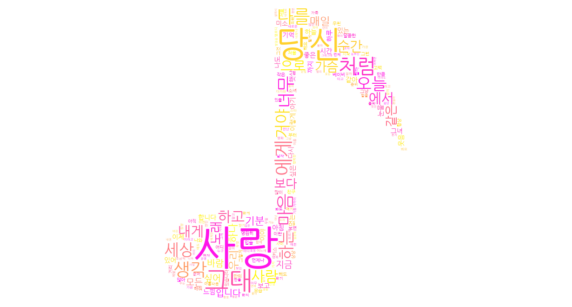

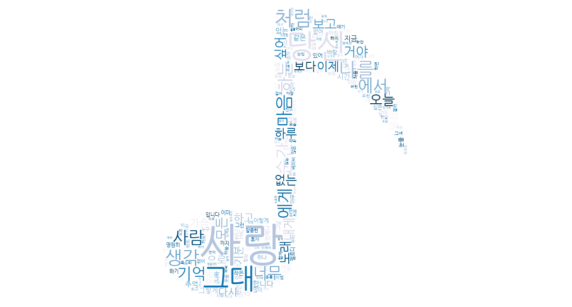

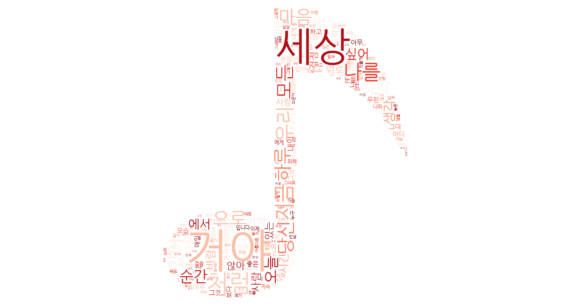

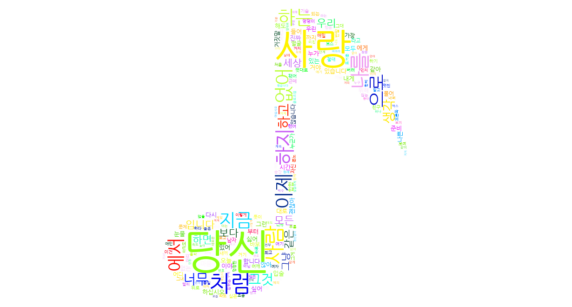

In [85]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# 웹사이트에서 iconpp.png라는 파일을 다운받아 분석 환경에 미리 upload 해줍니다.
icon=Image.open('/content/pngegg.png')
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)


!pip3 install wordcloud
from wordcloud import WordCloud
 
wc1 = WordCloud(font_path="/content/NanumGothic.ttf",                           #폰트
               background_color='white',                              #배경색
               width=800, height=600,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask,
              colormap = 'spring'
              ) 

wc2 = WordCloud(font_path='/content/NanumGothic.ttf',                           #폰트
               background_color='white',                              #배경색
               width=800, height=600,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask
                , colormap = 'PuBu'
              ) 

wc3 = WordCloud(font_path='/content/NanumGothic.ttf',                           #폰트
               background_color='white',                              #배경색
               width=800, height=600,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask
                , colormap = 'Reds'
              )  

wc4 = WordCloud(font_path='/content/NanumGothic.ttf',                           #폰트
               background_color='white',                              #배경색
               width=800, height=600,                                 #사이즈설정
               max_words=200                                          #단어갯수
                ,mask=mask
                , colormap = 'gist_ncar'
             )                                                      #마스크설정   

#행복 
cloud = wc1.generate_from_frequencies(goal_cnt_neg_happy)              #사전형태의 데이터
 
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud,interpolation="bilinear")

# 슬픔  
cloud = wc2.generate_from_frequencies(goal_cnt_neg_sad)              #사전형태의 데이터
 
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud,interpolation="bilinear")

# 분노 
cloud = wc3.generate_from_frequencies(goal_cnt_neg_anger)              #사전형태의 데이터
 
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud,interpolation="bilinear")

# 희망 
cloud = wc4.generate_from_frequencies(goal_cnt_neg_hope)              #사전형태의 데이터
 
plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기
plt.imshow(cloud,interpolation="bilinear")
